# Evaporation of water from $\beta$-lactalbumin fibril

In a separate Monte Carlo (MC) simulation we determined the bare molecular dipole moment of beta-lactalbumin to be **384 D** at pH 3.7. This is to be compared to **548 D** as presented in the work of [Rogers et al.](https://doi.org/10.1002/bip.20483) using a different theoretical model that neglects counter ions.
Both of these predictions reflect the _bare_ protein, i.e. the dipole moment without counter ions.

We here aim to determine the effective dipole moment per monomer in a fibril, taking into account that counter-ions will be present. This may be particularly important in the solid phase, where electrostatics may strongly couple the counter-ions to the protein molecules.

## Monte Carlo setup

Five proteins with counter-ions embedded in a cylindrical, periodic cell or radius 25 Å. The dielectric constant is set to 20 to mimic a partially water solvated fibril in water. During simulation, the proteins can translate along the $z$-axis and rotate around their mass-centers in any direction.
MC displacements of the cylinder length-axis is performed to relax the spacing between the proteins under zero tension.

![alt text](fibril.png "Snapshot from MC simulation of a periodic cylinder witb 5 proteins")

In [18]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json

def getBareDipoleMoment(output_json_file):
    ''' extract molecular dipole moment from out.json file (in Debye) '''
    to_debye = 1.0 / 0.2081943
    with open(output_json_file) as f:
        for analysis in json.load(f)['analysis']:
            for key, val in analysis.items():
                if key=='multipole':
                    multipole = val['molecules']['protein']
                    return multipole['μ'] * to_debye
    assert(False)
    
def getSystemDipoleMoment(filename):
    ''' dipole moment of entire system incl. counter-ions (Debye) '''
    to_debye = 1.0 / 0.2081943
    return np.loadtxt(filename, usecols=[2])[-1] * to_debye

## Bare dipole moment vs. effective dipole moment?

The results below show that the _effective dipole moment_ is significantly smaller than the bare protein dipole moment due to the presence of counter-ions. 

In [123]:
number_of_proteins = 5
mu_single_protein = getBareDipoleMoment('out.json')
print('Dipole moment of bare protein = {:.0f} D'.format(mu_single_protein))

mu_system = getSystemDipoleMoment('system_dipole_moment.dat.gz')
print('System dipole moment incl. counter ions = {:.0f} D'.format(mu_system))

mu_single_protein_with_counter_ions = mu_system / number_of_proteins
print('Dipole moment per protein incl. counter ions = {:.0f} D'.format(mu_single_protein_with_counter_ions))

print('Reduction due to counter-ions = {:.1f}'.format(
    mu_single_protein / mu_single_protein_with_counter_ions))

Dipole moment of bare protein = 385 D
System dipole moment incl. counter ions = 994 D
Dipole moment per protein incl. counter ions = 199 D
Reduction due to counter-ions = 1.9


## Alignment of system dipole moment along cell direction

We here investigate how the system dipole momement is aligned with respect to the cylinder length axis ($z$). This is done by averaging each squared compoment of the dipole moment vector, $\langle \mu_x^2 \rangle$.
If zero, no random alignment is expected, whereas unity means full alignment.

We see that the $x$ and $y$ axis are roughly equal which is a marker for convergence and roughly around 0.1. Not unexpectedly, the alignment along $z$ is much stronger, around 0.8.

In [115]:
def systemDipoleMomentVector():
    ''' unit dipole moment vector as a function of frames '''
    to_debye = 1.0 / 0.2081943
    mux = np.loadtxt('mu_x.dat.gz', usecols=[1]) * to_debye
    muy = np.loadtxt('mu_y.dat.gz', usecols=[1]) * to_debye
    muz = np.loadtxt('mu_z.dat.gz', usecols=[1]) * to_debye
    mu = np.vstack((mux, muy, muz))
    mu_len = np.sqrt((mu*mu).sum(axis=0))
    return mu / mu_len

def systemDipoleAlignment():
    mu_hat = systemDipoleMomentVector()
    return (mu_hat*mu_hat).mean(axis=1)

systemDipoleAlignment()

array([0.11588335, 0.11575404, 0.76836261])

## Tension along the cylinder length axis ($z$)

During simulation, the cylinder $z$-axis fluctuates and we sample the probability distribution of lengths. This is related to the free energy of compressing or elongating the cylinder and is governed by the intermolecular interactions within the (small) fibril. Note that the cylinder has periodic ends and thus proteins and counter ions interact across the edges.

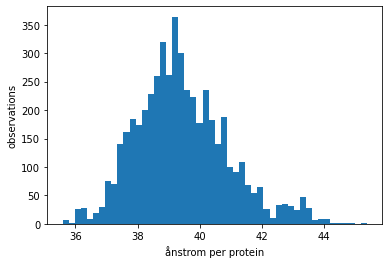

In [128]:
steps, zlen = np.loadtxt('zlen.dat.gz', usecols=[0,1], unpack=True)
plt.xlabel('ånstrom per protein')
plt.ylabel('observations')
hist = plt.hist(zlen / number_of_proteins, bins=50)

## Todo

- Increase parameter space: dielectric constant; cylinder radius; number of proteins
- Parallel tempering in $\varepsilon_r$. This will require MPI exchange of cylinder properties as we currently exchange the volume, only. Several values of the dielectric constant would mimic evaporation.
- Implement "real" structure of $\beta$-lactalbumin fibrils. Currently we have a simplistic description of the interactions, mainly due to electrostatics.